#**Apply SHAP to Dog-Cat Classifier**

Mount Google Drive folder.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load data using TF Dataset pipelines.

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

base_dir = "drive/My Drive/Teaching/Courses/NYU - Modern AI/Session 4-5/dogs-vs-cats"

train_dataset = image_dataset_from_directory(
    base_dir + "/train/",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir + "/validation/",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir + "/test/",
    image_size=(180, 180),
    batch_size=32)

Found 765 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 798 files belonging to 2 classes.


Define model...

In [3]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(180, 180, 3))

### Note that SHAP DeepExplainer doesn't know how to handle 'custom' layers.
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856 

Fit the model with a callback...

In [4]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="drive/My Drive/Teaching/Courses/NYU - Modern AI/Session 4-5/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
24/24 [==============================] - 8s 162ms/step - loss: 48.8312 - accuracy: 0.5203 - val_loss: 0.6995 - val_accuracy: 0.5100
Epoch 2/40
24/24 [==============================] - 2s 74ms/step - loss: 0.7524 - accuracy: 0.5438 - val_loss: 0.7112 - val_accuracy: 0.5350
Epoch 3/40
24/24 [==============================] - 2s 73ms/step - loss: 0.7190 - accuracy: 0.5490 - val_loss: 0.7095 - val_accuracy: 0.5175
Epoch 4/40
24/24 [==============================] - 2s 75ms/step - loss: 0.8325 - accuracy: 0.5124 - val_loss: 0.6512 - val_accuracy: 0.6175
Epoch 5/40
24/24 [==============================] - 2s 73ms/step - loss: 0.7287 - accuracy: 0.5673 - val_loss: 0.7380 - val_accuracy: 0.5100
Epoch 6/40
24/24 [==============================] - 2s 80ms/step - loss: 1.1264 - accuracy: 0.5961 - val_loss: 0.6433 - val_accuracy: 0.6450
Epoch 7/40
24/24 [==============================] - 2s 78ms/step - loss: 0.6558 - accuracy: 0.6261 - val_loss: 0.6374 - val_accuracy: 0.6175
Epoch 8/40


As before, this model gets to about 70% accuracy in the test data.

In [5]:
from tensorflow import keras

test_model = keras.models.load_model("drive/My Drive/Teaching/Courses/NYU - Modern AI/Session 4-5/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

25/25 [==============================] - 2s 60ms/step - loss: 0.6805 - accuracy: 0.5815
Test accuracy: 0.5814536213874817


#**SHAP Deep Explainer**

In [6]:
!pip install shap
import shap
import numpy as np
import glob
from PIL import Image

# Let's get 50 cats.
images = []
ind = 0
for file in glob.glob(f"{base_dir}/train/cats/*"):
    im=Image.open(file)
    im=im.resize(size=(180,180))
    images.append(np.divide(np.array(im),255))
    ind += 1
    if ind == 50:
      break

# Let's also get 50 dogs.
ind = 0
for file in glob.glob(f"{base_dir}/train/dogs/*"):
    im=Image.open(file)
    im=im.resize(size=(180,180))
    images.append(np.divide(np.array(im),255))
    ind += 1
    if ind == 50:
      break

background = np.stack(images)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


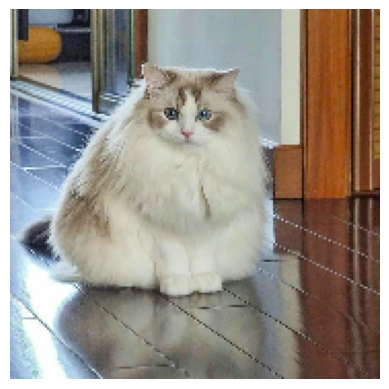

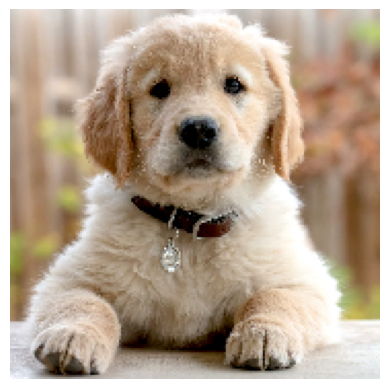

(2, 180, 180, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [7]:
import matplotlib.pyplot as plt

# explain predictions of the model on three images
e = shap.DeepExplainer(test_model, background)

cat_path = keras.utils.get_file(
    fname="cat6.jpg",
    origin="https://www.brightstarbuddies.com.au/blog/wp-content/uploads/sites/8/Bellamy.jpg")

dog_path = keras.utils.get_file(
    fname="dog.jpeg",
    origin="https://kb.rspca.org.au/wp-content/uploads/2018/11/golder-retriever-puppy.jpeg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

cat_tensor = get_img_array(cat_path, target_size=(180, 180))
dog_tensor = get_img_array(dog_path, target_size=(180, 180))

plt.axis("off")
plt.imshow(cat_tensor[0].astype("uint8"))
plt.show()
plt.axis("off")
plt.imshow(dog_tensor[0].astype("uint8"))
plt.show()

test_set = np.stack((cat_tensor,dog_tensor),axis=0)
test_set = test_set[:, 0, :, :, :]
print(test_set.shape)

# For some reason we have an extra dimension to our shap_values output.
# Dropping the extra dimension from the shap_values tensor using np.squeeze()
shap_values = e.shap_values(test_set)

Note that I'm indexing the shap_values tensor to drop an extra (unecessary) dimension that the function is returning.

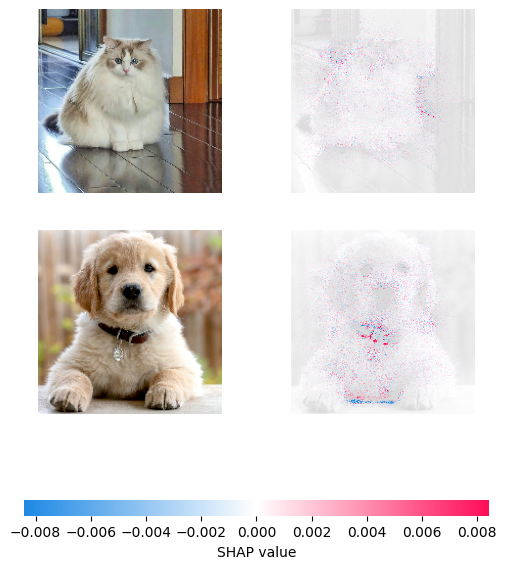

In [17]:
shap.image_plot(shap_values[:,:,:,:,0],pixel_values=test_set.astype('uint8'))